## Import Necessary Libraries

In [ ]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import os                  
from random import shuffle
from tqdm import tqdm  
import random
#for opening and loading image - Image Processing
from PIL import Image
import cv2   
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

## Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Images in Directory

In [ ]:
# setting path of directory
ROOT_DIR = "/content/drive/MyDrive/Skin-Cancer-Classification/skin_cancer_dataset/"
BASAL_CELL_DIR = "Basal_cell_carcinoma/"
MELANOMA_DIR = "Melanoma/"
NEVUS_DIR = "Nevus/"
TRAIN_DIR = "train/"
TEST_DIR = "test/"

# setting train directory path for each category
BASAL_CELL_TRAIN_DIR = os.path.join(ROOT_DIR, BASAL_CELL_DIR, TRAIN_DIR)
MELANOMA_TRAIN_DIR = os.path.join(ROOT_DIR, MELANOMA_DIR, TRAIN_DIR)
NEVUS_TRAIN_DIR = os.path.join(ROOT_DIR, NEVUS_DIR, TRAIN_DIR)

# setting test directory path for each category
BASAL_CELL_TEST_DIR = os.path.join(ROOT_DIR, BASAL_CELL_DIR, TEST_DIR)
MELANOMA_TEST_DIR = os.path.join(ROOT_DIR, MELANOMA_DIR, TEST_DIR)
NEVUS_TEST_DIR = os.path.join(ROOT_DIR, NEVUS_DIR, TEST_DIR)



In [ ]:
basal_images = os.listdir(BASAL_CELL_TRAIN_DIR)
melanoma_images = os.listdir(MELANOMA_TRAIN_DIR)
nevus_images = os.listdir(NEVUS_TRAIN_DIR)

print('No of Images in Basal Cell Carcinoma :', len(basal_images))
print('No of Images in Melanoma :', len(melanoma_images))
print('No of Images in Nevus :', len(nevus_images))

No of Images in Basal Cell Carcinoma : 1877
No of Images in Melanoma : 1908
No of Images in Nevus : 1885


## Checking Sample Images 

In [ ]:
def check_sample_images(samples_list, n, sample_dir):
  sample_images = random.sample(samples_list,n)
  sample_dir_path = sample_dir + '/'
  train_images_dir = os.path.join(ROOT_DIR, sample_dir_path, TRAIN_DIR)


  f,ax = plt.subplots(n//3,n//2,figsize=(15,9))
  for i in range(0,n):
    img = cv2.imread(train_images_dir + sample_images[i])
    ax[i//(n//2),i%(n//2)].imshow(img)
    ax[i//(n//2),i%(n//2)].axis('off')
  f.suptitle(f"{sample_dir} Sample Images",fontsize=20)
  plt.show()


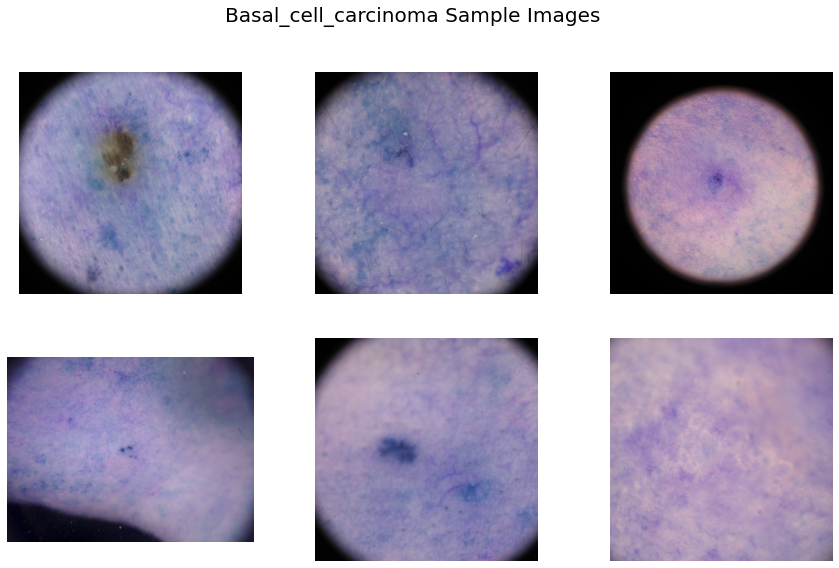

In [ ]:
check_sample_images(basal_images, n = 6, sample_dir = "Basal_cell_carcinoma")

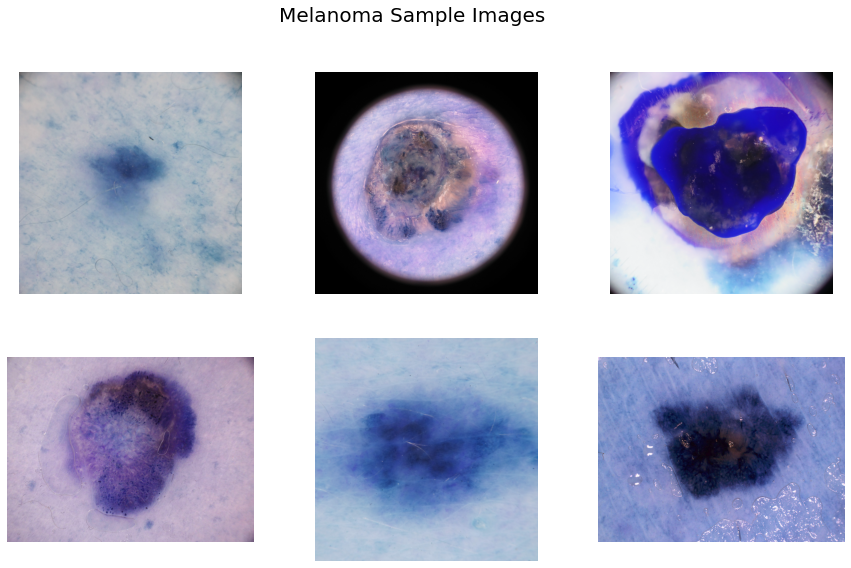

In [ ]:
check_sample_images(melanoma_images, n = 6, sample_dir = "Melanoma")

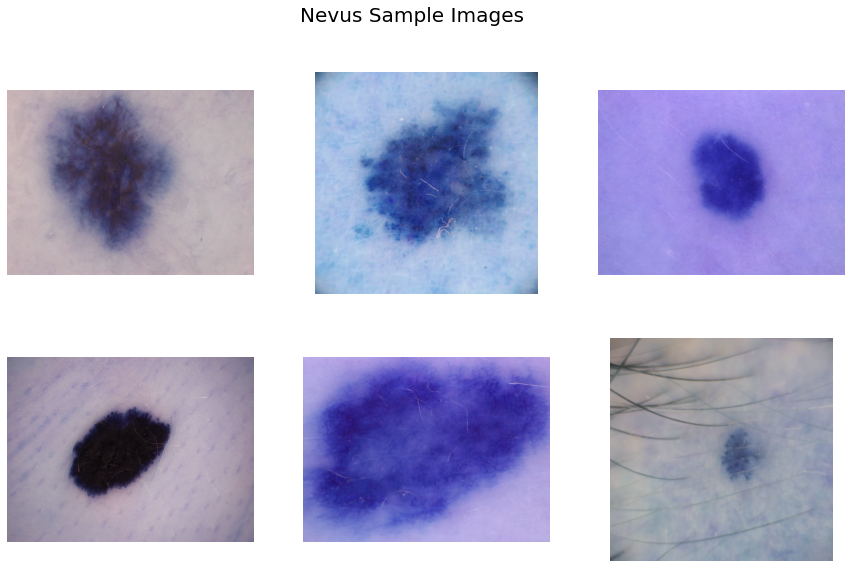

In [ ]:
check_sample_images(nevus_images, n = 6, sample_dir = "Nevus")

## Data Preparation - Loading Images and Labels

In [ ]:
data=[]
labels=[]

def load_images_labels(images_dir, label):
  train_images_dir = os.listdir(images_dir)
  for img in train_images_dir:
    try:
        image = cv2.imread(images_dir + img)
        image_from_array = Image.fromarray(image, 'RGB')
        resized_image = image_from_array.resize((224, 224))
        data.append(np.array(resized_image))
        labels.append(label)
    except AttributeError:
        print("")

In [ ]:
# for Basal Cell Carcinoma
load_images_labels(BASAL_CELL_TRAIN_DIR, label=0)

In [ ]:
# for Melanoma
load_images_labels(MELANOMA_TRAIN_DIR, label=1)

In [ ]:
# for Nevus
load_images_labels(NEVUS_TRAIN_DIR, label=2)

In [ ]:
print("Data :", len(data))
print("Labels :", len(labels))

Data : 5670
Labels : 5670


In [ ]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save(f"{ROOT_DIR}feats_train", feats)
np.save(f"{ROOT_DIR}labels_train", labels)

## Loading saved data and labels

In [ ]:
features = np.load(f"{ROOT_DIR}feats_train.npy")
labels = np.load(f"{ROOT_DIR}labels_train.npy")

## Randomizing Data and Labels

In [ ]:
s = np.arange(features.shape[0])
np.random.shuffle(s)
features = features[s]
labels = labels[s]

In [ ]:
num_classes=len(np.unique(labels))
print(num_classes)

3


In [ ]:
data_length = len(features)
print(data_length)

5670


## Train Test Split

In [ ]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(X_train, X_test) = features[(int)(0.2*data_length):],features[:(int)(0.2*data_length)]

(y_train, y_test) = labels[(int)(0.2*data_length):],labels[:(int)(0.2*data_length)]

## Image Data Normalization

In [ ]:
# As we are working on image data so we are normalizing data by dividing 255.
X_train = X_train.astype('float32')/255 
X_test = X_test.astype('float32')/255
train_len = len(X_train)
test_len = len(X_test)

In [ ]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Data Augmentation

In [ ]:
data_generator  = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

## Model Building

In [ ]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
# define callbacks
callbacks = [ModelCheckpoint('model_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30
print("[INFO] training head...")
history = model.fit(
	data_generator.flow(X_train,y_train, batch_size=BATCH_SIZE),
	steps_per_epoch=train_len // BATCH_SIZE,
	validation_data=(X_test, y_test),
	validation_steps=test_len // BATCH_SIZE,
	epochs=EPOCHS,callbacks=callbacks)

[INFO] training head...
Epoch 1/30
70/70 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.6999
Epoch 1: val_loss improved from inf to 17.88569, saving model to model_wts.hdf5
70/70 [==============================] - 100s 884ms/step - loss: 0.7026 - accuracy: 0.6999 - val_loss: 17.8857 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7710
Epoch 2: val_loss did not improve from 17.88569
70/70 [==============================] - 56s 799ms/step - loss: 0.5651 - accuracy: 0.7710 - val_loss: 19.7154 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7898
Epoch 3: val_loss improved from 17.88569 to 16.27835, saving model to model_wts.hdf5
70/70 [==============================] - 57s 804ms/step - loss: 0.5194 - accuracy: 0.7898 - val_loss: 16.2784 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 4/30
70/70 [========================

## Save the Model

In [ ]:
model = load_model('model_wts.hdf5')
model.save('/content/drive/MyDrive/Skin-Cancer-Classification/mobilenet_model.h5')

## Load the Model Again..

In [ ]:
model = load_model('/content/drive/MyDrive/Skin-Cancer-Classification/mobilenet_model.h5')
# checking the loss and accuracy 
results = model.evaluate(X_test, y_test, verbose=1)
print('\n', 'Test Loss:-', results[0])
print('\n', 'Test Accuracy:-', results[1])

36/36 [==============================] - 9s 51ms/step - loss: 0.3547 - accuracy: 0.9339

 Test Loss:- 0.35474690794944763

 Test Accuracy:- 0.9338624477386475


In [ ]:
rounded_predictions = model.predict(X_test, batch_size=16, verbose=0)
rounded_predictions[1]

array([1.3373647e-11, 1.0000000e+00, 4.3896775e-11], dtype=float32)

In [ ]:
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels = np.argmax(y_test, axis=1)

y_pred = model.predict(X_test, batch_size = 16, verbose = True)

71/71 [==============================] - 2s 21ms/step


## Plotting Confusion Matrix and Classification Report

In [ ]:

TEST_BATCH_SIZE = 16
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test, batch_size=TEST_BATCH_SIZE)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis=1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, y_pred_classes)

71/71 [==============================] - 2s 21ms/step


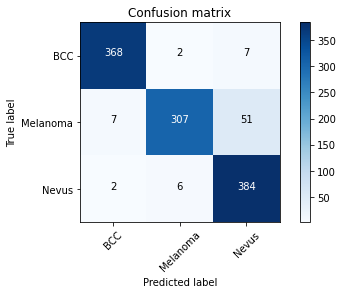

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes)) 

In [ ]:
# show a nicely formatted classification report
print(classification_report(rounded_labels, y_pred_classes,target_names=['BCC','Melanoma','Nevus']))

              precision    recall  f1-score   support

         BCC       0.98      0.98      0.98       377
    Melanoma       0.97      0.84      0.90       365
       Nevus       0.87      0.98      0.92       392

    accuracy                           0.93      1134
   macro avg       0.94      0.93      0.93      1134
weighted avg       0.94      0.93      0.93      1134



## Prepare Test (New) Data

In [ ]:
test_data=[]
test_labels=[]

def load_test_images_labels(images_dir, label):
  test_images_dir = os.listdir(images_dir)
  for img in test_images_dir:
    try:
        image = cv2.imread(images_dir + img)
        image_from_array = Image.fromarray(image, 'RGB')
        resized_image = image_from_array.resize((224, 224))
        test_data.append(np.array(resized_image))
        test_labels.append(label)
    except AttributeError:
        print("")

In [ ]:
# for Basal Cell Carcinoma - Test
load_test_images_labels(BASAL_CELL_TEST_DIR, label=0)

In [ ]:
# for Melanoma - Test
load_test_images_labels(MELANOMA_TEST_DIR, label=1)

In [ ]:
# for Nevus - Test
load_test_images_labels(NEVUS_TEST_DIR, label=2)

In [ ]:
print("Test Data :", len(test_data))
print("Test Labels :", len(test_labels))

Test Data : 300
Test Labels : 300


In [ ]:
#converting features and labels in array
test_features = np.array(test_data)
test_labels = np.array(test_labels)

# saving features and labels for later re-use
np.save(f"{ROOT_DIR}feats_test", test_features)
np.save(f"{ROOT_DIR}labels_test", test_labels)

In [ ]:
test_features = np.load(f"{ROOT_DIR}feats_test.npy")
test_labels = np.load(f"{ROOT_DIR}labels_test.npy")

In [ ]:
num_classes_test = len(np.unique(test_labels))
print(num_classes_test) 

3


In [ ]:
len_test_data = len(test_features)
print(len_test_data)

300


In [ ]:
X_valid = test_features.astype('float32')/255
y_valid = to_categorical(test_labels,num_classes_test)

In [ ]:
# Predict the values from the new dataset
y_pred_new = model.predict(X_valid, batch_size=TEST_BATCH_SIZE)
# Convert predictions classes to one hot vectors 
y_pred_classes_new = np.argmax(y_pred_new,axis=1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels_new = np.argmax(y_valid, axis=1)
confusion_mtx_new = confusion_matrix(rounded_labels_new, y_pred_classes_new)

19/19 [==============================] - 1s 63ms/step


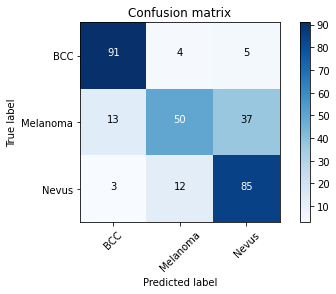

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_new, classes = range(num_classes_test)) 

## Plotting Sample Predictions

36/36 [==============================] - 1s 40ms/step


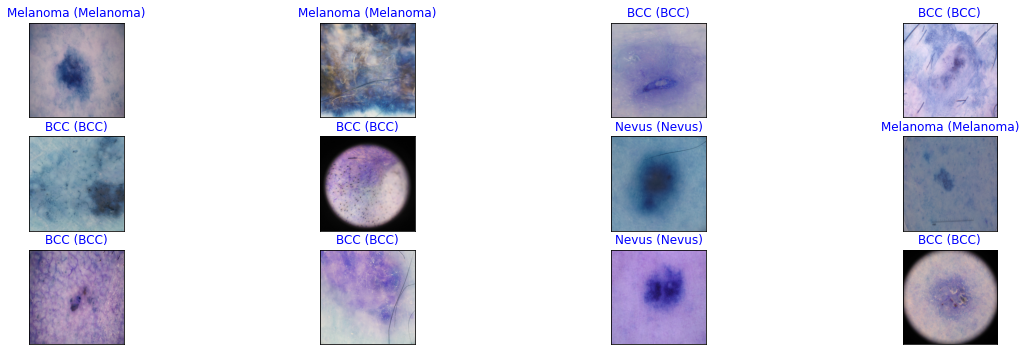

In [ ]:
y_hat = model.predict(X_test)

# define text labels 
skin_labels = ['BCC','Melanoma','Nevus']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

## Prediction on Single Image

In [ ]:
# single image path
single_img = "/content/drive/MyDrive/Skin-Cancer-Classification/skin_cancer_dataset/Nevus/test/Nevus_ISIC_0000111_downsampled.jpg"

In [ ]:
class_dict ={0:"Basal_Cell_Carcinoma (Cancer)",
             1:"Melanoma (Cancer)",
             2:"Nevus (Non-Cancerous)"}

In [ ]:
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255
  
  preds = model.predict(img)[0]
  prediction = sorted(
      [(class_dict[i], round(j*100, 2)) for i, j in enumerate(preds)],
      reverse=True,
      key=lambda x: x[1]
  )
  
  return prediction

In [ ]:
pred_image(single_img,model)

1/1 [==============================] - 0s 356ms/step


[('Nevus (Non-Cancerous)', 100.0),
 ('Basal_Cell_Carcinoma (Cancer)', 0.0),
 ('Melanoma (Cancer)', 0.0)]